In [1]:
# eliminar la memoria cache 

import torch
torch.cuda.empty_cache()

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Montar Google Drive para acceder a los datos
# from google.colab import drive
# drive.mount('/content/drive')

# Ruta del dataset en Google Drive
# dataset = '//content/drive/MyDrive/Colab Notebooks/M15S19/imagenes'

In [3]:
# Ruta principal donde están las subcarpetas de las clases
dataset = r"C:\Users\Diego\M5-UDD\Clase 3\Clase 3\imagenes"

## Analisis Exploratorio del dataset

In [4]:
import os

# Listar las carpetas de las clases
classes = os.listdir(dataset)
print(f"Clases detectadas: {classes}")

Clases detectadas: ['autos', 'aviones', 'camiones']


In [5]:
# Contar la cantidad de imágenes en cada clase
for class_name in classes:
    class_path = os.path.join(dataset, class_name)
    if os.path.isdir(class_path):
        print(f"{class_name}: {len(os.listdir(class_path))} imágenes")


autos: 20 imágenes
aviones: 20 imágenes
camiones: 20 imágenes


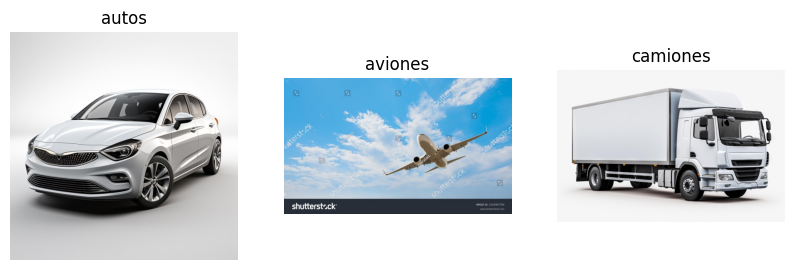

In [6]:
# Visualizamos una imagen por cada carpeta
from PIL import Image
import matplotlib.pyplot as plt

# Mostrar una imagen de cada clase
plt.figure(figsize=(10, 5))
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset, class_name)
    first_image_path = os.path.join(class_path, os.listdir(class_path)[0])
    img = Image.open(first_image_path)

    plt.subplot(1, len(classes), i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()


In [7]:
# Visualizamos las dimensiones, los canales, los bits y el formato de cada imagen 

from PIL import Image, UnidentifiedImageError
import os

# Extensiones soportadas, agrega si tienes otro formato distinto
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}

# Inspeccionar cada imagen y extraer sus características
for class_name in os.listdir(dataset):
    class_path = os.path.join(dataset, class_name)
    if os.path.isdir(class_path):
        print(f"\nClase: {class_name}")
        images = os.listdir(class_path)

        for img_name in images:
            img_path = os.path.join(class_path, img_name)

            # Verificar extensión del archivo
            if not os.path.splitext(img_path)[1].lower() in valid_extensions:
                print(f"Archivo no soportado (omitido): {img_name}")
                continue

            try:
                # Abrir y analizar la imagen
                with Image.open(img_path) as img:
                    dimensions = img.size  # (ancho, alto)
                    mode = img.mode  # Modo de color (e.g., RGB, L, etc.)
                    bits = img.bits if hasattr(img, 'bits') else 'Desconocido'  # Bits por canal
                    fmt = img.format  # Formato de la imagen
                    print(f"Imagen: {img_name} - Dimensiones: {dimensions}, Canales: {mode}, Bits: {bits}, Formato: {fmt}")
            except UnidentifiedImageError:
                print(f"Error: No se pudo identificar la imagen: {img_name}")



Clase: autos
Imagen: auto001.jpg - Dimensiones: (826, 826), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto002.jpg - Dimensiones: (1380, 789), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto003.jpg - Dimensiones: (1060, 795), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto004.jpg - Dimensiones: (1800, 900), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto005.jpg - Dimensiones: (1380, 920), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto006.jpg - Dimensiones: (1380, 920), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto007.jpg - Dimensiones: (996, 796), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto008.jpg - Dimensiones: (1380, 776), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto009.jpg - Dimensiones: (1380, 776), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto010.jpg - Dimensiones: (1380, 776), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto011.jpg - Dimensiones: (1380, 776), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto012.jpg - Dimensiones: (1380, 776), Canal

## Creamos el modelo de red neuronal convolucional

In [9]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# ====== Configuración inicial ======
# dataset = "ruta/a/tu/dataset"  # 🔁 CAMBIA esto a la ruta de tu dataset
img_height, img_width = 128, 128
num_classes = 3
batch_size = 8
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # moviendo la red a GPU
print(f"Usando dispositivo: {device}")

# ====== Cargar imágenes y etiquetas ======
x_data = []
labels = []

for class_name in os.listdir(dataset):
    class_path = os.path.join(dataset, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                try:
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize((img_width, img_height))
                    x_data.append(np.array(img, dtype=np.float32) / 255.0)
                    labels.append(class_name)
                except Exception as e:
                    print(f"Error al procesar {img_name}: {e}")

x_data = np.array(x_data)
labels = np.array(labels)

# ====== Codificar etiquetas ======
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(labels)

# ====== Dataset personalizado ======
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x).permute(0, 3, 1, 2)  # (N, C, H, W)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# ====== División de datos ======
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ====== Arquitectura del modelo ======
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.25)

        self.flatten_dim = 64 * 30 * 30  # Asumiendo imagen de entrada de 128x128
        self.fc1 = nn.Linear(self.flatten_dim, 512)
        self.drop3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.drop1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.drop2(x)

        x = x.view(-1, self.flatten_dim)
        x = F.relu(self.fc1(x))
        x = self.drop3(x)
        x = self.fc2(x)
        return x

# ====== Entrenamiento ======
model = CNNModel(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-6)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Ep {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Acc: {train_acc:.4f}")

# ====== Evaluación ======
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")


Usando dispositivo: cuda
Ep 1/50 - Loss: 29.1990 - Acc: 0.2917
Ep 2/50 - Loss: 1.0810 - Acc: 0.3125
Ep 3/50 - Loss: 1.0331 - Acc: 0.6458
Ep 4/50 - Loss: 1.0187 - Acc: 0.5417
Ep 5/50 - Loss: 0.9741 - Acc: 0.6042
Ep 6/50 - Loss: 0.8986 - Acc: 0.6667
Ep 7/50 - Loss: 0.8103 - Acc: 0.7708
Ep 8/50 - Loss: 1.1392 - Acc: 0.7292
Ep 9/50 - Loss: 0.8751 - Acc: 0.6250
Ep 10/50 - Loss: 0.8864 - Acc: 0.7083
Ep 11/50 - Loss: 0.5099 - Acc: 0.9167
Ep 12/50 - Loss: 0.4806 - Acc: 0.8542
Ep 13/50 - Loss: 0.4489 - Acc: 0.8333
Ep 14/50 - Loss: 0.3160 - Acc: 0.9167
Ep 15/50 - Loss: 0.4901 - Acc: 0.8750
Ep 16/50 - Loss: 0.5069 - Acc: 0.8750
Ep 17/50 - Loss: 0.2210 - Acc: 0.9792
Ep 18/50 - Loss: 0.2189 - Acc: 0.9583
Ep 19/50 - Loss: 0.1812 - Acc: 0.9583
Ep 20/50 - Loss: 0.1223 - Acc: 0.9792
Ep 21/50 - Loss: 0.1761 - Acc: 0.9583
Ep 22/50 - Loss: 0.1830 - Acc: 0.9792
Ep 23/50 - Loss: 0.2535 - Acc: 0.9167
Ep 24/50 - Loss: 1.1792 - Acc: 0.9167
Ep 25/50 - Loss: 0.5412 - Acc: 0.7500
Ep 26/50 - Loss: 0.3421 - Acc: 0.